# Word embeddings approach using LSA/LSI

Though the fuzzy similarity approach (based on Levenshtein distance)
seem to work on several cases in the USP data,
most of the correct results should be *almost* normalized
in order to have a small edit distance.
The fuzzy approach will neither fill empty fields,
nor fix huge mistakes in what had been filled.
To do that, we were looking at the remaining fields
using a graph approach.
The adjacency matrix entries should be normalized
using both the row and column frequencies,
but that won't fix entries
whose contents had been "swapped" among the columns.

The goal here is to use a topic modeling approach,
using a word embedding matrix
instead of using the CSV columns
(i.e., each word is a feature, no matter where it came from).
This is a Latent Semantic Analysis (LSA) from the TF-IDF matrix,
ending with a K Nearest Neighbors classification model
to fill the empty fields.

*PS: LSI stands for Latent Semantic Indexing.*

In [1]:
import random
import re

Install the following packages with:

```
pip install gensim matplotlib numpy pandas scikit-learn unidecode
```

In [2]:
from gensim import corpora, matutils, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster, neighbors, metrics, model_selection
from unidecode import unidecode

In [3]:
random.seed(42)
pd.options.display.max_colwidth = 400 # Avoid "..." in large strings
pd.options.display.max_rows = 120     # Avoid "..." in the table representation of lengthy dataframes
%matplotlib inline

## Pre-normalized word list

We'll get only the words in the fields that aren't IDs/numbers/symbols,
and pre-normalize it by removing accents and symbols,
and by lowercasing everything.

It's the same CSV from Clea's output analyzed in the previous experiments.

In [4]:
TEXT_ONLY_REGEX = re.compile("[^a-zA-Z ]")

In [5]:
def pre_normalize(name):
    return TEXT_ONLY_REGEX.sub("", unidecode(name).lower())

In [6]:
dataset = pd.read_csv("inner_join_2018-06-04.csv",
                      dtype=str,
                      keep_default_na=False) \
            .drop_duplicates()

In [7]:
fields = [
    "addr_city",
    "addr_country",
    "addr_country_code",
    "addr_state",
    "aff_text",
    "article_title",
    "contrib_bio",
    "contrib_prefix",
    "contrib_name",
    "contrib_surname",
    "institution_orgdiv1",
    "institution_orgdiv2",
    "institution_orgname",
    "institution_orgname_rewritten",
    "institution_original",
    "institution_orgname_rewritten",
    "journal_title",
    "publisher_name",
]

In [8]:
word_lists = dataset[fields].T.apply(lambda row: pre_normalize(" ".join(row)).split())
word_lists.head()

0    [brazil, br, e, doutora, em, sociologia, pela, universidade, federal, do, rio, grande, do, sul, ufrgs, e, professora, do, programa, de, posgraduacao, em, ciencia, politica, e, do, programa, de, posgraduacao, em, politicas, publicas, desta, mesma, universidade, email, ligiamorimadeiragmailcom, universidade, federal, do, rio, grande, do, sul, universidade, federal, do, rio, grande, do, sul, ufrg...
1    [brazil, br, e, professor, do, departamento, de, sociologia, da, universidade, federal, do, rio, grande, do, sul, ufrgs, integrando, o, programa, de, posgraduacao, em, sociologia, e, o, programa, de, posgraduacao, em, desenvolvimento, rural, coordena, o, grupo, de, pesquisa, associativismo, contestacao, e, engajamento, gpace, wwwufrgsbrgpace, email, mksilvaufrgsbr, universidade, federal, do, r...
2    [brazil, br, e, professora, do, instituto, federal, sulriograndense, ifsul, campus, sapucaia, do, sul, doutoranda, no, programa, de, posgraduacao, em, sociologia, integra, o, gpace, ema

The $5$ word lists above regards to the first $5$ entries in the CSV.
Are we able to predict the empty fields from an embedding
created from the word lists?

At first, there are too many distinct words!
We should remove words that won't help us.

In [9]:
dictionary = corpora.Dictionary(word_lists)
len(dictionary) # "Raw" word count

102136

Let's remove:

* Words that appear in less than $3$ documents (rows of the CSV);
* Some cherry-picked Brazilian Portuguese stop words;
* Words that has only a single character (`d`, `y`, `a`, `o`, etc.).

In [10]:
uncommon_words = [token for token, tid in dictionary.token2id.items() if dictionary.dfs[tid] <= 2]
stop_words = ["da", "de", "desta", "do", "em", "ii", "iii", "in", "mesma", "no", "pela", "pelos"]
single_char_words = [token for token in dictionary.token2id if len(token) == 1]

In [11]:
dictionary.filter_tokens(bad_ids=[dictionary.token2id[token]
                                  for token in uncommon_words + stop_words + single_char_words])
dictionary.compactify()
len(dictionary) # Word count after filtering

48712

More than half of the words had been removed.

## BoW and TF-IDF

The *bag of words* model for the entire corpus
and the TF-IDF are:

In [12]:
corpus = [dictionary.doc2bow(wlist) for wlist in word_lists]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Let's see what's going on for the first few words and documents.

In [13]:
num2plot = 400
csc_corpus = matutils.corpus2csc(corpus, num_terms=len(dictionary))
csc_tfidf = matutils.corpus2csc(corpus_tfidf, num_terms=len(dictionary))

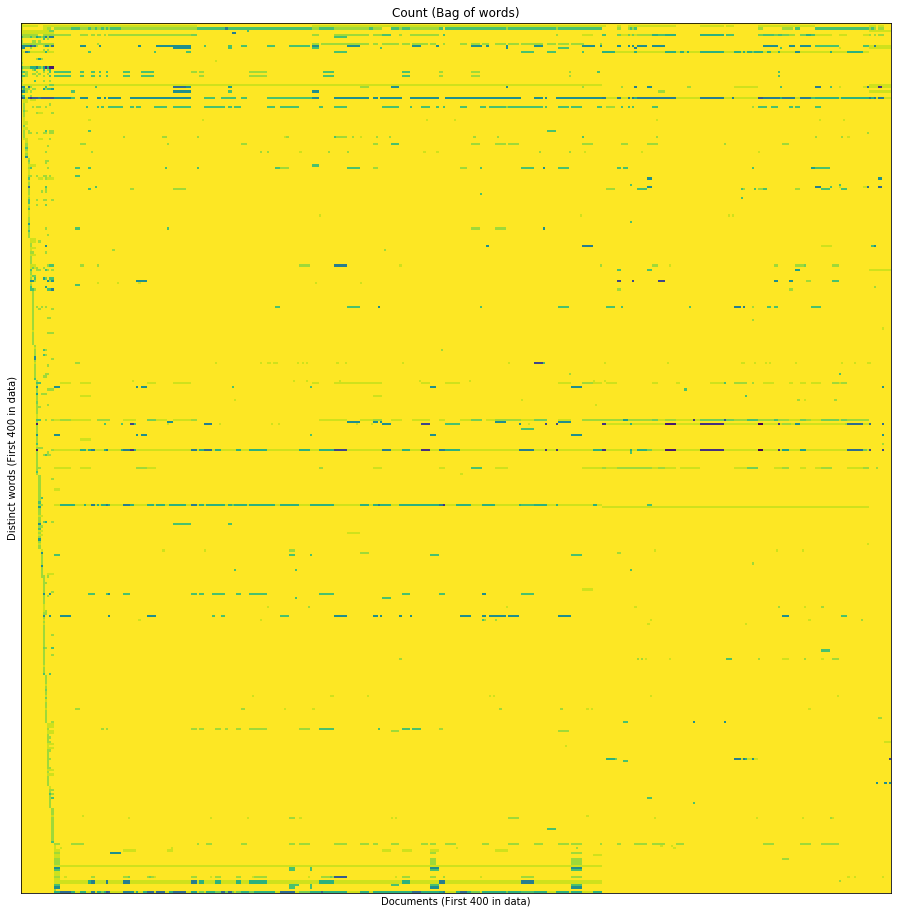

In [14]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_corpus[:num2plot, :num2plot].todense(), cmap=plt.cm.viridis_r)
ax.set(title="Count (Bag of words)",
       xticks=[], xlabel=f"Documents (First {num2plot} in data)",
       yticks=[], ylabel=f"Distinct words (First {num2plot} in data)");

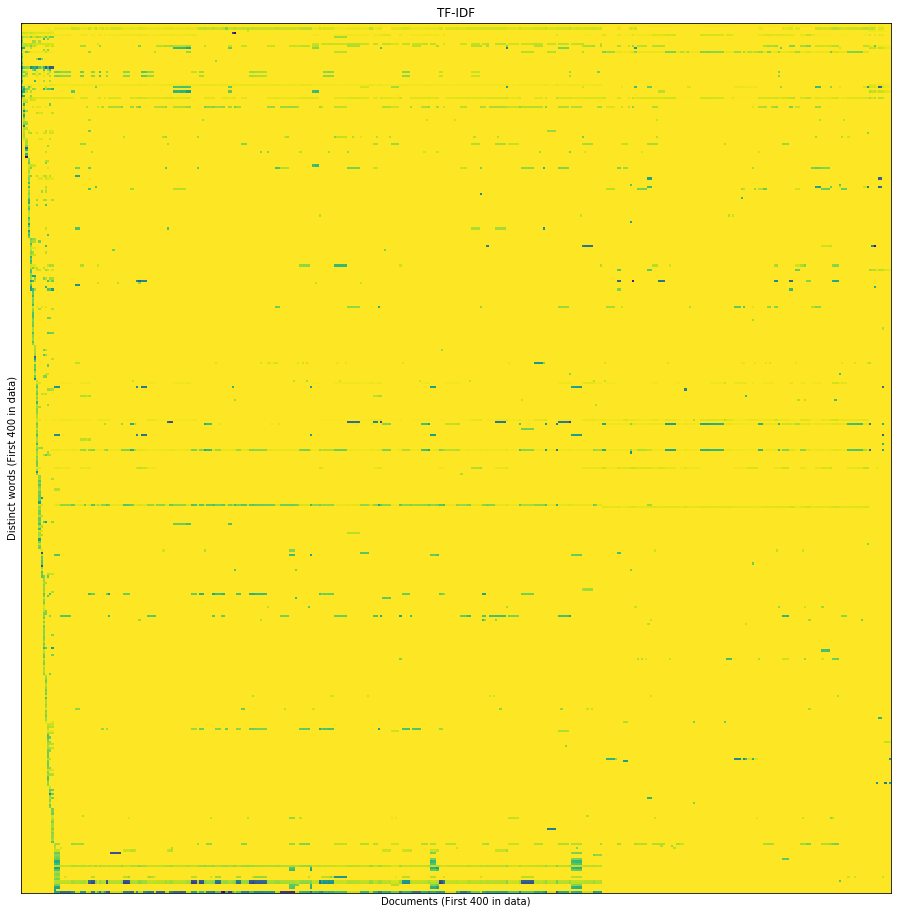

In [15]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_tfidf[:num2plot, :num2plot].todense(), cmap=plt.cm.viridis_r)
ax.set(title="TF-IDF",
       xticks=[], xlabel=f"Documents (First {num2plot} in data)",
       yticks=[], ylabel=f"Distinct words (First {num2plot} in data)");

Each row in these plots regards to a single word,
and each column regards to a single document
(an affiliation-contributor `<aff>` and `<contrib>` pair).
The first plot has the raw count of words in each cell
(each column is a *bag of words*).

The "line" with a quite negative slope at the left
happens due to the first time each word appeared in the documents,
as we're seeing the first indices in the dictionary.
The horizontal line at the bottom shows that there's a single word
that appears in several documents, but the lack of greenish elements
at its right shows it's quite informative:
the simplest approach to a classification would be querying
if that word appears in the document.

The distinction between the *Count/BoW* plot and the *TF-IDF* plot
is of a normalization nature.
TF-IDF means *Term Frequency (times) Inverse Document Frequency*,
that is:

$$
\operatorname{tfidf}(t, d, D) = \operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)
$$

Where $t$ is a term, $d$ is a document and $D$ is the dictionary.
In the `gensim` implementation,
$\operatorname{tf}$ is the raw term count in the document,
$\operatorname{idf}$ is the negative logarithm (base $2$) of the proportion of
documents that have the given term,
and the overall result (i.e., the vector of TF-IDF for a given document)
is normalized/scaled to unit norm/length.

Let's try to see this result by plotting the $400$ words
and $400$ documents whose TF-IDF entries have the largest variances
(row-wise for the terms/words, column-wise for the documents).

In [16]:
var_docs = (
    csc_tfidf.power(2).mean(axis=0) - csc_tfidf.mean(axis=0).A ** 2
).A.ravel()
var_terms = (
    csc_tfidf.power(2).mean(axis=1) - csc_tfidf.mean(axis=1).A ** 2
).A.ravel()

maxvar_docs_idx = np.argsort(var_docs)[-num2plot:]
maxvar_terms_idx = np.argsort(var_terms)[-num2plot:]

csc_corpus_block = csc_corpus[maxvar_terms_idx].T \
                             [maxvar_docs_idx].T.todense()
csc_tfidf_block = csc_tfidf[maxvar_terms_idx].T \
                           [maxvar_docs_idx].T.todense()

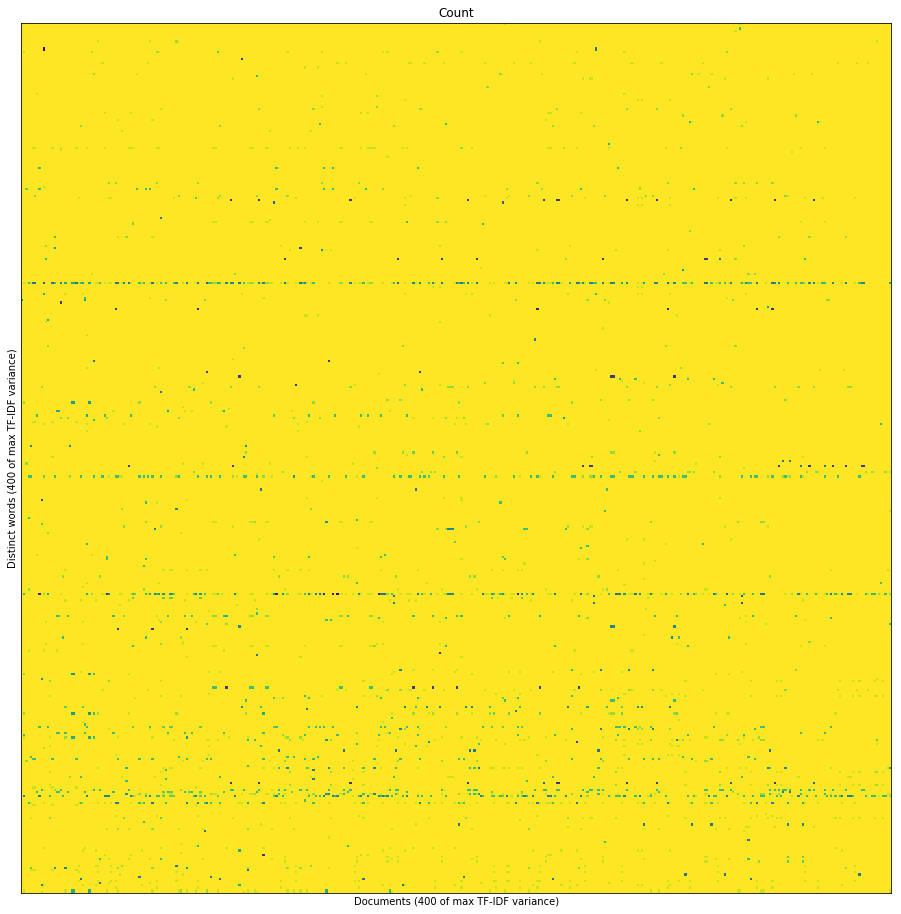

In [17]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_corpus_block, cmap=plt.cm.viridis_r)
ax.set(title="Count",
       xticks=[], xlabel=f"Documents ({num2plot} of max TF-IDF variance)",
       yticks=[], ylabel=f"Distinct words ({num2plot} of max TF-IDF variance)");

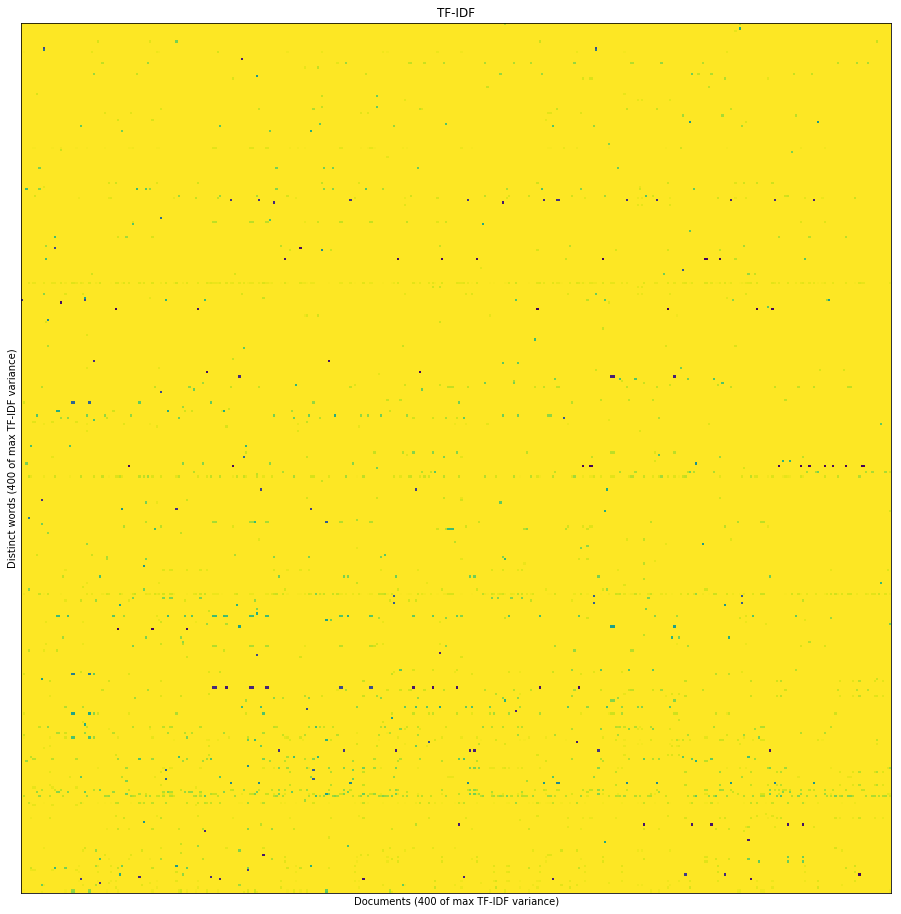

In [18]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_tfidf_block, cmap=plt.cm.viridis_r)
ax.set(title="TF-IDF",
       xticks=[], xlabel=f"Documents ({num2plot} of max TF-IDF variance)",
       yticks=[], ylabel=f"Distinct words ({num2plot} of max TF-IDF variance)");

Though these last images represents the same data,
the TF-IDF is more yellowish / cleaner.
That means a lot of words that has a high value in the BoW model
aren't informative for document discrimination.

## LSI - Latent Semantic Indexing

The randomness suggests there are some information we can directly use to create classifiers.

The goal here is to remove redundancy from that huge matrix by lowering its rank.
The whole idea is to minimize the, given our TF-IDF matrix $\mathbf{X}$, we can perform SVD:

$$
\mathbf{X} = \mathbf{U} \cdot \mathbf{\Sigma} \cdot \mathbf{V}^T
$$

As we know, its transpose is:

$$
\begin{array}{rcl} \displaystyle
\mathbf{X}^T
& \displaystyle = & \displaystyle
  \left( \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T \right)^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
\end{array}
$$

Where $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices
(i.e., their transpose are their inverse).
Actually their columns are the eigenvectors of
$\mathbf{X} \mathbf{X}^T$ and $\mathbf{X}^T \mathbf{X}$ since:

$$
\begin{array}{rcl} \displaystyle
\mathbf{X} \mathbf{X}^T
& \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^{-1}
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma} \mathbf{\Sigma}^T \mathbf{U}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma}_U^2 \mathbf{U}^T
\end{array}
$$

And:

$$
\begin{array}{rcl} \displaystyle
\mathbf{X}^T \mathbf{X}
& \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^{-1}
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{\Sigma} \mathbf{V}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}_V^2 \mathbf{V}^T
\end{array}
$$

Lowering the rank is just zeroing *the smallest singular values $\sigma_i$ in $\mathbf{\Sigma}$*.
That is, we perform SVD, replace the smallest singular values by zero, and resynthesize the matrix with:

$$
\mathbf{X}_k = \mathbf{U} \cdot \mathbf{\Sigma}_k \cdot \mathbf{V}^T
$$

The magnitude of the matrix measured by its Frobenius norm is also lowered,
but in some sense the changes are the smaller they could be, since
the Frobenius norm of $\mathbf{X}$ is:

$$
||\mathbf{X}||_F = \sqrt{\sum_{i=1}^n \sum_{j=1}^m x_{ij}^2}
                 = \sqrt{\operatorname{tr} \left( \mathbf{X}^T \mathbf{X} \right) }
                 = \sqrt{\operatorname{tr} \left( \mathbf{V} \mathbf{\Sigma}_V^2 \mathbf{V}^T \right) }
                 = \sqrt{\operatorname{tr} \left( \mathbf{V}^T \mathbf{V} \mathbf{\Sigma}_V^2 \right) }
                 = \sqrt{\operatorname{tr} \left( \mathbf{\Sigma}_V^2 \right) }
                 = \sqrt{\sum \sigma_i^2 }
$$

(Remind the trace of a product is invariant under cyclic permutation)

Actually, we don't need to fully resynthesize the matrix.
To apply the model directly from the SVD results
on a $\mathbf{d}$ vector having a single document TF-IDF,
we need to perform $\pmb{\Sigma}_k^{-1} \mathbf{U} \mathbf{d}$,
but the `gensim` model by default doesn't apply the scaling factor
$\pmb{\Sigma}_k^{-1}$ (a diagonal matrix
with the inverse of the largest $k$ singular values
and zeros for the remaining dimensions).

Let's perform this, through the `gensim` LSI model:

In [19]:
num_topics = 200
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)
corpus_lsi = lsi[corpus_tfidf]
matrix_lsi = matutils.corpus2dense(corpus_lsi, num_terms=lsi.num_topics)

This matrix has a vector for each entry in our corpus,
represented in a word embedding space.

In [20]:
matrix_lsi.shape

(200, 89451)

It's a more compact representation for the "randomness" we've seen in TF-IDF,
*blurring* the TF-IDF results (by lowering the TF-IDF matrix rank).

In [21]:
lsi_block = lsi.projection.u[maxvar_terms_idx, :] \
          @ np.diag(lsi.projection.s) \
          @ (matrix_lsi[:, maxvar_docs_idx])

This is what the TF-IDF selection became, after lowering the matrix rank:

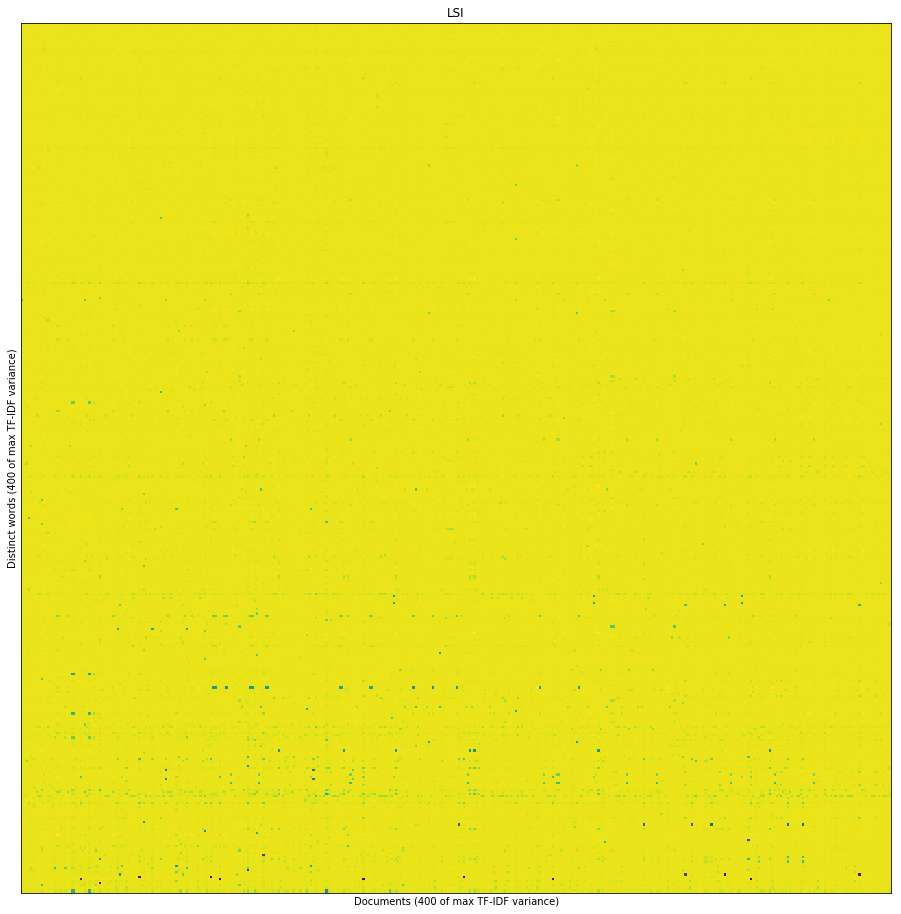

In [22]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(lsi_block, cmap=plt.cm.viridis_r)
ax.set(title="LSI",
       xticks=[], xlabel=f"Documents ({num2plot} of max TF-IDF variance)",
       yticks=[], ylabel=f"Distinct words ({num2plot} of max TF-IDF variance)");

Okay, but how can we use that matrix for clustering/classification?

## K-Means clustering of the LSI matrix data

We can try to find clusters with something like K-Means.
That's simple, yet it would be difficult to find any meaning to label that data.

In [23]:
kmeans_model = cluster.KMeans(5, random_state=1234).fit(matrix_lsi.T)
classes = kmeans_model.predict(matrix_lsi.T)
dataset.assign(**{"class": classes}).head().T

,0,1,2,3,4
addr_city,,,,,
addr_country,Brazil,Brazil,Brazil,Brazil,Brazil
addr_country_code,BR,BR,BR,BR,BR
addr_postal_code,,,,,
addr_state,,,,,
aff_email,ligiamorimadeira@gmail.com,mksilva@ufrgs.br,bianca.or@gmail.com,mrviegas@gmail.com,cardososampaio@gmail.com
aff_id,aff1,aff1,aff2,aff1,aff1
aff_text,* É doutora em Sociologia pela Universidade Federal do Rio Grande do Sul (UFRGS) e professora do Programa de Pós-Graduação em Ciência Política e do Programa de Pós-Graduação em Políticas Públicas desta mesma universidade. E-mail: <ligiamorimadeira@gmail.com>. Universidade Federal do Rio Grande do Sul Universidade Federal do Rio Grande do Sul (UFRGS) Brazil ligiamorimadeira@gmail.com,"* É professor do Departamento de Sociologia da Universidade Federal do Rio Grande do Sul (UFRGS), integrando o Programa de Pós-Graduação em Sociologia e o Programa de Pós-Graduação em Desenvolvimento Rural. Coordena o Grupo de Pesquisa Associativismo, Contestação e Engajamento (GPACE) - <www.ufrgs.br/gpace>. E-mail: <mksilva@ufrgs.br>. Universidade Federal do Rio Grande do Sul Universidade Fed...","** É professora do Instituto Federal Sul-rio-grandense (IFSUL), campus Sapucaia do Sul. Doutoranda no Programa de Pós-Graduação em Sociologia, integra o GPACE. E-mail: <bianca.or@gmail.com>. Instituto Federal Sul-rio-grandense Instituto Federal Sul-rio-grandense (IFSUL) Brazil bianca.or@gmail.com","* É sociólogo, mestre em Sociologia e Antropologia e doutor em Planejamento Urbano e Regional pela Universidade Federal do Rio de Janeiro (UFRJ). Atualmente é pesquisador da Fundação Instituto de Pesca do Estado do Rio de Janeiro (Fiperj), professor do Centro Universitário de Volta Redonda (Unifoa) e pesquisador vinculado ao Laboratório Estado, Trabalho, Território e Natureza do Instituto de P...",* É professor de Ciência Política na Universidade Federal do Paraná (UFPR). Doutor em Comunicação e Cultura Contemporâneas pela Universidade Federal da Bahia (UFBA). Pesquisador-associado do Centro de Estudos Avançados em Democracia Digital (CEADD) da UFBA e do Centro de Estudos Internacional do Governo (Cegov) da Universidade Federal do Rio Grande do Sul (UFRGS). E-mail: <cardososampaio@gmail...
article_doi,10.1590/0103-335220162102,10.1590/0103-335220162106,10.1590/0103-335220162106,10.1590/0103-335220162101,10.1590/0103-335220162108
article_publisher_id,,,,,


The class of these few examples seem to have to do with the institution name,
yet it's hard to label it that way with just $5$ classes.
Perhaps a supervised learning approach would yield better results.

## Supervised learning - Train/Test split

We need to split our data in order to evaluate the results.
That assumes the inputs are mostly correct,
a quite reassuring assumption
(we couldn't do much if that's not true).
The input data should be split in $3$:
a *training* set, a *testing* set, and a *unknown* set.
Predictions on the latter should be evaluated manually.

However, we should re-create an LSI without
the text from the column we're trying to predict.
The following function helps us on that:

In [24]:
def create_dict_with_lsi_model(dataset, fields, num_topics, bad_tokens):
    word_lists = dataset[fields].T.apply(lambda row: pre_normalize(" ".join(row)).split())
    dictionary = corpora.Dictionary(word_lists)
    dictionary.filter_tokens(bad_ids=[dictionary.token2id[token]
                                      for token in uncommon_words + stop_words + single_char_words
                                      if token in dictionary.token2id])
    dictionary.compactify()
    corpus = [dictionary.doc2bow(wlist) for wlist in word_lists]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)
    corpus_lsi = lsi[corpus_tfidf]
    matrix_lsi = matutils.corpus2dense(corpus_lsi, num_terms=lsi.num_topics)
    return locals().copy() # Shallow

This is a quite slow command that does almost everything we did,
but without the contents from the `addr_country` and `addr_country_code` columns,
the ones we wish to predict from the remaining data.

In [25]:
y_fields = ["addr_country_code", "addr_country"]
lsi_addr_country_code_dict = create_dict_with_lsi_model(
    dataset=dataset,
    fields=[f for f in fields if f not in y_fields],
    num_topics=num_topics,
    bad_tokens=uncommon_words + stop_words + single_char_words,
)

For now, we want to find the country code,
which seem to be simpler to evaluate the classification results
than the country name, due to the lack of input normalization.
Given that, we can split our data in the $3$ parts,
as previously described.

In [26]:
y_field = y_fields[0]
df_lsi = pd.DataFrame(lsi_addr_country_code_dict["matrix_lsi"].T,
                      index=dataset.index)
df_lsi_filled_selector = dataset[y_field] != ""

X_unk = df_lsi[~df_lsi_filled_selector]

X = df_lsi[df_lsi_filled_selector]
y = dataset[df_lsi_filled_selector][y_field]

y_counts = y.value_counts()
y_strata = y.replace(y_counts[y_counts == 1].index, "")

X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y,
                                     test_size=.3,
                                     random_state=1234,
                                     stratify=y_strata)

## Classification of the LSI to fill the country code

As our data is quite unbalanced,
naive models could easily be biased towards the most common country code,
which has more than $83\%$ of the input data:

In [27]:
y_train_counts = y_train.value_counts()
y_train_counts["BR"] / y_train_counts.sum()

0.8356959034721343

The kNN model with $k = 5$ should be ok with that unbalanced input,
y "neglecting" any huge cluster sets that might exist
far away from the input document to be classified,
as well as "neglecting" any single spurious input.
That is, we're going to use the matrix for a distance approach
(Euclidean, but almost in a Mahalanobis-like sense
due to the nature of the matrix),
looking for clusters that have at least $3$ inputs,
not something that naively tries to maximize the overall accuracy
in a Bayesian sense.

In [28]:
%%time
knn_models = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(),
    param_grid={"n_neighbors": [1, 3, 5, 7]},
    return_train_score=True,
)
knn_models.fit(X_train, y_train);

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


CPU times: user 32min, sys: 3.17 s, total: 32min 3s
Wall time: 32min 10s


As it seems, the nearest neighbor classifier (i.e., kNN with $k = 1$)
is the best model when it comes to the accuracy:

In [29]:
knn_model = knn_models.best_estimator_
knn_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [30]:
knn_models.cv_results_

{'mean_fit_time': array([0.35987719, 0.37965306, 0.38245916, 0.39978647]),
 'std_fit_time': array([0.0021417 , 0.00995168, 0.00319489, 0.02954038]),
 'mean_score_time': array([31.85744317, 59.09071231, 74.78299848, 83.25442759]),
 'std_score_time': array([0.15807581, 0.44986784, 1.37694098, 0.41945506]),
 'param_n_neighbors': masked_array(data=[1, 3, 5, 7],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 7}],
 'split0_test_score': array([0.96233676, 0.95369377, 0.94896221, 0.94486152]),
 'split1_test_score': array([0.9637181 , 0.9531438 , 0.9501678 , 0.94845818]),
 'split2_test_score': array([0.9666286 , 0.95812714, 0.9540033 , 0.95222687]),
 'mean_test_score': array([0.96422394, 0.9549846 , 0.95103995, 0.94850863]),
 'std_test_score': array([0.00178848, 0.00222924, 0.00214863, 0.00300752]),
 'rank_test_score': array([1, 2, 3, 4], dtype=int3

In [31]:
%%time
y_pred = knn_model.predict(X_test)

CPU times: user 46.9 s, sys: 49.6 ms, total: 46.9 s
Wall time: 47 s


It's a pretty high accuracy:

In [32]:
metrics.accuracy_score(y_test, y_pred)

0.9703710995176691

Below we have a table with precision, recall and F1 scores
for the countries that have at least $10$ entries in the dataset.
The F1 score is quite high only for the most common classes,
but **US** and **IT**.
For codes like **GB** this model is clearly failing.

In [33]:
print(metrics.classification_report(y_test, y_pred, labels=y_counts[y_counts >= 10].index))

             precision    recall  f1-score   support

         BR       1.00      0.99      1.00     16979
         CN       0.99      0.97      0.98       426
         PT       0.96      0.98      0.97       306
         US       0.75      0.79      0.77       297
         TR       0.95      0.95      0.95       255
         AR       0.94      0.97      0.95       207
         ES       0.79      0.84      0.81       180
         CO       0.93      0.95      0.94       162
         MX       0.99      0.96      0.97       160
         IR       0.96      0.95      0.96       124
         IN       0.82      0.91      0.86       124
         CL       0.98      0.93      0.95       111
         FR       0.77      0.88      0.82        83
         IT       0.71      0.78      0.75        73
         GB       0.35      0.42      0.38        62
         DE       0.57      0.68      0.62        53
         MY       0.98      0.98      0.98        52
         PK       0.83      0.81      0.82   

This average weighted by the *support* (number of entries)
is a quite bad measurement for such an unbalanced data.

Let's convert that data to a DataFrame to get more information from it.

In [34]:
prfs_tuple = metrics.precision_recall_fscore_support(y_test, y_pred,
                                                     labels=knn_model.classes_)
prfs_df = pd.DataFrame(np.array(prfs_tuple).T,
                       index=knn_model.classes_.tolist(),
                       columns=["precision", "recall", "f1score", "support"]) 

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


The rows with a support of at least $6$ elements
(i.e., with at least $6$ entries in the `y_test`):

In [35]:
prfs_df_top = prfs_df[prfs_df["support"] > 5] \
    .sort_values(["f1score", "support"], ascending=False) \
    .assign(support_proportion=lambda df: df["support"] / prfs_df["support"].sum())
prfs_df_top

,precision,recall,f1score,support,support_proportion
BR,0.998281,0.991755,0.995007,16979.0,0.835910
MY,0.980769,0.980769,0.980769,52.0,0.002560
CN,0.985714,0.971831,0.978723,426.0,0.020973
PT,0.961661,0.983660,0.972536,306.0,0.015065
MX,0.987097,0.956250,0.971429,160.0,0.007877
IR,0.959350,0.951613,0.955466,124.0,0.006105
CL,0.980952,0.927928,0.953704,111.0,0.005465
AR,0.938967,0.966184,0.952381,207.0,0.010191
TR,0.948819,0.945098,0.946955,255.0,0.012554
CO,0.927711,0.950617,0.939024,162.0,0.007976


The average of these colums NOT weighted by the support are:

In [36]:
prfs_df_top.mean()

precision               0.728385
recall                  0.751819
f1score                 0.735309
support               412.285714
support_proportion      0.020298
dtype: float64

The support average is meaningless,
yet this average F1 score
should be seen as a better quality measure
for the trained kNN classifier.

We can see the above data in a "heat"/image plot:

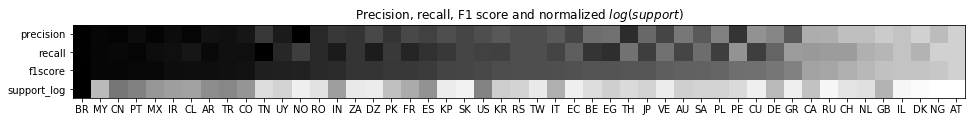

In [37]:
support_log = np.log2(prfs_df_top["support"])
prfs_image_df = prfs_df_top.assign(support_log=support_log / support_log.max()) \
                           .drop(columns=["support", "support_proportion"])
fig, ax = plt.subplots(figsize=(16, 2))
ax.grid(False)
ax.imshow(prfs_image_df.T, cmap=plt.cm.gray_r)
ax.set(
    title="Precision, recall, F1 score and normalized $log(support)$",
    xticks=range(prfs_image_df.shape[0]),
    xticklabels=prfs_image_df.index,
    yticks=range(prfs_image_df.shape[1]),
    yticklabels=prfs_image_df.columns,
);

The logarithm is applied on the support
(the squares/pixels at the bottom row)
to give some sense of the proportion.
Data is sorted by the F1 score (3rd row).